In [29]:
data_dim_str = "T24H-X850M-Y880M"  # needs to exist
data_path = f"./data/processed/{data_dim_str}/"    


conf_dict = {
    "seed":3,
    "resume":False,
    "early_stopping":False,
    "use_weighted_sampler":True,
    "use_cuda":False,
    "val_ratio":0.1,
    "tst_ratio":0.2,
    "lr":1e-3,
    "weight_decay":1e-8,
    "max_epochs":10,
    "batch_size":80,
    "shuffle":False,
    "num_workers":6,
    "seq_len":0,
}

conf = BaseConf(conf_dict=conf_dict)

In [30]:
datagroup = CrimeDataGroup(data_path=data_path, conf=conf)

In [ ]:
datagroup.training_set

In [4]:
zip_file = np.load(data_path + "generated_data.npz")
for k,v in zip_file.items():
    print(f"{k} shape {np.shape(v)}")
    
t_range = pd.read_pickle(data_path + "t_range.pkl")    
print(f"t_range shape {np.shape(t_range)}")

crime_feature_indices shape (11,)
crime_types_grids shape (365, 11, 47, 33)
crime_grids shape (365, 1, 47, 33)
demog_grid shape (1, 37, 47, 33)
street_grid shape (1, 512, 47, 33)
time_vectors shape (366, 43)
weather_vectors shape (365, 11)
x_range shape (33,)
y_range shape (47,)
t_range shape (366,)


In [23]:
time_vectors.shape

(366, 43)

In [27]:
time_vectors = zip_file["time_vectors"]
time_vectors.max(0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1.])

### testing data structure and folding

In [ ]:
import numpy as np
# use as index testing

shape = n,c,h,w = 100,3,12,11

flat_list = []
for t in range(n):
    for y in range(h):
        for x in range(w):
            flat_list.append([t,y,x])
            
            
flat_arr = np.array(flat_list)
arr = np.reshape(flat_arr,newshape=shape)


t,y,x = 34,6,7

index = np.ravel_multi_index(multi_index=(t,y,x), dims=(n,h,w))
np.unravel_index(index,shape=(n,h,w))


# Todo `AUC` over time and if re-training is needed

In [ ]:
np.stack()

### sub_sampling time dataframes

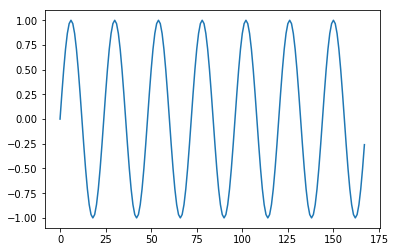

In [36]:
T = 24
f = 1/f
x = np.arange(T*7)

y = np.sin(2*np.pi*x*f)
import matplotlib.pyplot as plt
plt.plot(x,y)
plt.show()

In [37]:
import pandas as pd

In [64]:
data_dim_str = "T24H-X850M-Y880M"  # needs to exist
model_name = "FNN-CRIME-MODEL"  # needs to be created

data_path = f"./data/processed/{data_dim_str}/"
zip_file = np.load(data_path + "generated_data.npz")

# print info on the read data
log.info("Data shapes of files in generated_data.npz")
for k, v in zip_file.items():
    print(f"\t{k} shape {np.shape(v)}")
t_range = pd.read_pickle(data_path + "t_range.pkl")
print(f"\tt_range shape {np.shape(t_range)}")
weather_vectors = zip_file["weather_vectors"]

	crime_feature_indices shape (11,)
	crime_types_grids shape (365, 11, 47, 33)
	crime_grids shape (365, 1, 47, 33)
	demog_grid shape (1, 37, 47, 33)
	street_grid shape (1, 512, 47, 33)
	time_vectors shape (366, 43)
	weather_vectors shape (365, 11)
	x_range shape (33,)
	y_range shape (47,)
	t_range shape (366,)


DatetimeIndex(['2014-01-01', '2014-01-02', '2014-01-03', '2014-01-04',
               '2014-01-05', '2014-01-06', '2014-01-07', '2014-01-08',
               '2014-01-09', '2014-01-10',
               ...
               '2014-12-22', '2014-12-23', '2014-12-24', '2014-12-25',
               '2014-12-26', '2014-12-27', '2014-12-28', '2014-12-29',
               '2014-12-30', '2014-12-31'],
              dtype='datetime64[ns]', length=365, freq='D')

In [95]:
t_range = pd.date_range("2014-01-01","2015-01-01",freq="4H")

# resample weather data
weather_date_range = pd.date_range("2014-01-01",periods=len(weather_vectors),freq="1D")
weather_df = pd.DataFrame(weather_vectors,index=weather_date_range)

time_frame = t_range.freqstr
is_gte_24hours = 'D' in time_frame or time_frame == '24H'

if is_gte_24hours:
    weather_df = weather_df.resample(time_frame).mean()
else:
    weather_df = df.resample(time_frame).pad()
np.shape(weather_df.values)


(2185, 11)

In [98]:
6*365

2190

In [94]:
weather_df

,0,1,2,3,4,5,6,7,8,9,10
2014-01-01 00:00:00,0.288462,0.269231,0.307692,0.403846,0.365385,0.358491,0.674419,0.638889,0.434783,0.153846,1.0
2014-01-01 12:00:00,0.288462,0.269231,0.307692,0.403846,0.365385,0.358491,0.674419,0.638889,0.434783,0.153846,1.0
2014-01-02 00:00:00,0.230769,0.230769,0.211538,0.346154,0.346154,0.207547,0.674419,0.750000,0.695652,0.230769,1.0
2014-01-02 12:00:00,0.230769,0.230769,0.211538,0.346154,0.346154,0.207547,0.674419,0.750000,0.695652,0.230769,1.0
2014-01-03 00:00:00,0.173077,0.211538,0.134615,0.230769,0.288462,0.169811,0.744186,0.805556,0.260870,1.000000,0.0
2014-01-03 12:00:00,0.173077,0.211538,0.134615,0.230769,0.288462,0.169811,0.744186,0.805556,0.260870,1.000000,0.0
2014-01-04 00:00:00,0.365385,0.365385,0.365385,0.480769,0.480769,0.377358,0.441860,0.333333,0.000000,0.384615,1.0
2014-01-04 12:00:00,0.365385,0.365385,0.365385,0.480769,0.480769,0.377358,0.441860,0.333333,0.000000,0.384615,1.0
2014-01-05 00:00:00,0.250000,0.326923,0.153846,0.346154,0.461538,0.132075,0.488372,0.416667,0.478261,0.000000,1.0
2014-01-05 12:00:00,0.250000,0.326923,0.153846,0.346154,0.461538,0.132075,0.488372,0.416667,0.478261,0.000000,1.0


In [56]:
start_date = "2014-01-01"
end_date = "2014-01-08"

t_range = pd.date_range(start_date, end_date, freq="1H")[:-1]
s = pd.Series(y, index=t_range)

In [51]:
r = s.resample('24H').max()

In [60]:
s.resample('30min').pad()

2014-01-01 00:00:00    0.000000e+00
2014-01-01 00:30:00    0.000000e+00
2014-01-01 01:00:00    2.588190e-01
2014-01-01 01:30:00    2.588190e-01
2014-01-01 02:00:00    5.000000e-01
2014-01-01 02:30:00    5.000000e-01
2014-01-01 03:00:00    7.071068e-01
2014-01-01 03:30:00    7.071068e-01
2014-01-01 04:00:00    8.660254e-01
2014-01-01 04:30:00    8.660254e-01
2014-01-01 05:00:00    9.659258e-01
2014-01-01 05:30:00    9.659258e-01
2014-01-01 06:00:00    1.000000e+00
2014-01-01 06:30:00    1.000000e+00
2014-01-01 07:00:00    9.659258e-01
2014-01-01 07:30:00    9.659258e-01
2014-01-01 08:00:00    8.660254e-01
2014-01-01 08:30:00    8.660254e-01
2014-01-01 09:00:00    7.071068e-01
2014-01-01 09:30:00    7.071068e-01
2014-01-01 10:00:00    5.000000e-01
2014-01-01 10:30:00    5.000000e-01
2014-01-01 11:00:00    2.588190e-01
2014-01-01 11:30:00    2.588190e-01
2014-01-01 12:00:00    1.224647e-16
2014-01-01 12:30:00    1.224647e-16
2014-01-01 13:00:00   -2.588190e-01
2014-01-01 13:30:00   -2.588